#  Deep Learning (CSL7590): Assigment-1 (Designing a CNN )


 # Importing the libraries required


In [20]:
pip install idx2numpy

In [21]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import idx2numpy as im

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
data_a= '/content/drive/MyDrive/Deep Learning 2024/train-images.idx3-ubyte'
data_b = '/content/drive/MyDrive/Deep Learning 2024/train-labels.idx1-ubyte'
data_c= '/content/drive/MyDrive/Deep Learning 2024/t10k-images.idx3-ubyte'
data_d = '/content/drive/MyDrive/Deep Learning 2024/t10k-labels.idx1-ubyte'
train_x = im.convert_from_file(data_a)
train_y = im.convert_from_file(data_b)
test_x = im.convert_from_file(data_c)
test_y = im.convert_from_file(data_d)
# Printing the shapes of our dataset viz training and test dataset
print(f"{train_x.shape} is the shape of training data")
print(f"{train_y.shape} is the shape of training data labels")
print(f"{test_x.shape} is the shape of test data")
print(f"{test_y.shape} is the shape of test data labels")

(60000, 28, 28) is the shape of training data
(60000,) is the shape of training data labels
(10000, 28, 28) is the shape of test data
(10000,) is the shape of test data labels


# Exploratory Data Analysis of the given dataset

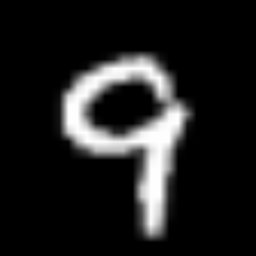

In [23]:
# Visualising the dataset to see how the images look
from google.colab.patches import cv2_imshow
import cv2
cv2_imshow(cv2.resize(train_x[9896], (256, 256)))

Sample images from the given dataset are as: 


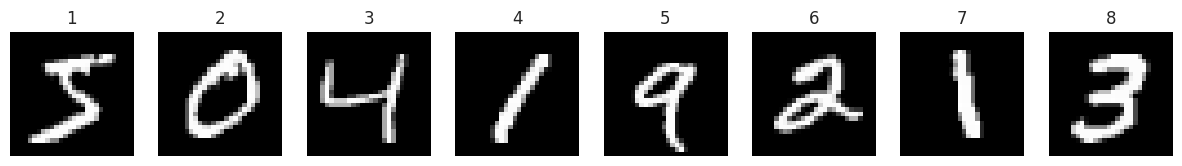

In [24]:
# Checking for the sample images present in our dataset
import matplotlib.pyplot as plt
print("Sample images from the given dataset are as: ")
def display(data):
    f,ax = plt.subplots(1,8, figsize=(15,15))
    for i in range(8):
        ax[i].imshow(data[i], cmap='gray')
        ax[i].set_title(f"{i+1}")
        ax[i].axis('off')
    plt.show()
display(train_x)

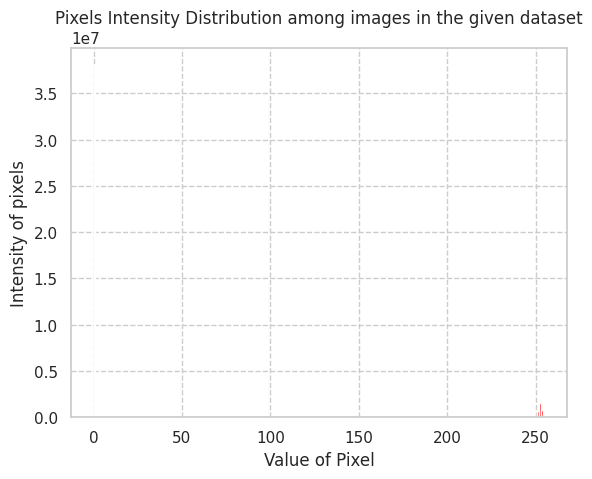

In [25]:
# Checking for distribution of the intensity of pixels in the images
import matplotlib.pyplot as plt
plt.hist(train_x.flatten(),bins=256,color='red')
plt.title('Pixels Intensity Distribution among images in the given dataset')
plt.xlabel('Value of Pixel')
plt.ylabel('Intensity of pixels')
plt.grid(axis='both', linestyle='--')
plt.show()

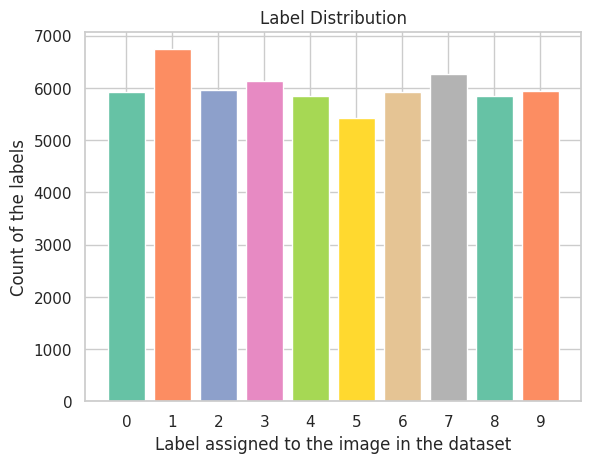

In [26]:
# Determining the label occurences in the dataset
import seaborn as sns
lab_num= np.bincount(train_y)
labels = np.arange(len(lab_num))
sns.set(style="whitegrid")
plt.bar(labels, lab_num, color=sns.color_palette('Set2', len(lab_num)))
plt.title('Label Distribution')
plt.xlabel('Label assigned to the image in the dataset')
plt.ylabel('Count of the labels')
plt.xticks(labels)
plt.show()

# Construction of the CNN Architecture

In [27]:
# Training data size
print("The training data size is: " ,train_x.size)
print("The training data label size is: " ,train_y.size)


The training data size is:  47040000
The training data label size is:  60000


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

In [86]:
class CNNArch(nn.Module):
  def __init__(self, lab):
    nn.Module.__init__(self)
    con1_par = {'in_channels':1,'out_channels':16,'kernel_size':7,'stride':1,'padding':3}
    self.conv1 = nn.Conv2d(**con1_par)
    con2_par = {'in_channels':16,'out_channels':8,'kernel_size':5,'stride':1,'padding':2}
    self.conv2 = nn.Conv2d(**con2_par)
    con3_par = {'in_channels':8,'out_channels':4,'kernel_size':3,'stride':1,'padding':1}
    self.conv3 = nn.Conv2d(**con3_par)
    full_layer_par = {'in_features':4*3*3,'out_features':lab}
    self.fc_layer = nn.Linear(**full_layer_par)
    #self.dp_flayer= nn.Dropout(p=0.2)
    self.softmax= nn.Softmax(dim=1)
    self.mpool = nn.MaxPool2d(2,2)
    self.apool= nn.AvgPool2d(2,2)
  def forward(self,x):
    x=self.conv1(x)
    x=func.relu(x)
    x=self.mpool(x)
    x=self.conv2(x)
    x=func.relu(x)
    x=self.mpool(x)
    x=self.conv3(x)
    x=func.relu(x)
    x=self.apool(x)
    x=torch.flatten(x,start_dim=1)
    x=self.fc_layer(x)
    #x=self.dp_flayer(x)
    x=self.softmax(x)
    return x
print(CNNArch)

<class '__main__.CNNArch'>


# Training the model

In [30]:
#Convert data to pytorch tensors
import torch
def convert(x,y):
  x = torch.tensor(x,dtype=torch.float32).unsqueeze(1)
  y = torch.tensor(y,dtype=torch.long)
  return x,y


In [31]:
# Loading the data so that we can able to train the model by passing our training data into it
import torch
from torch.utils.data import TensorDataset, DataLoader
def data_loading(train_x, train_y, batch_size=32, shuffle=True):
    train_data = TensorDataset(train_x, train_y)
    train_load = DataLoader(train_data, batch_size=32, shuffle=True)
    return train_load


In [32]:
from torch.optim import lr_scheduler
def criteria(cnn_mod):
  loss_cr = nn.CrossEntropyLoss()
  opt = optim.Adam(cnn_mod.parameters(), lr=0.001, weight_decay= 1e-4)
  sch = lr_scheduler.StepLR(opt, step_size=5, gamma=0.9)
  return loss_cr,opt,sch

In [33]:
cnn_mod =CNNArch(10)

In [34]:
train_x, train_y = convert(train_x,train_y)

In [35]:
training_data = data_loading(train_x,train_y)

In [36]:
loss_cr, opt,sch = criteria(cnn_mod)

In [37]:
def model_training(cnn_mod,training_data,opt,loss_cr,epochs,sch):
  loss_hist=[]
  acc_hist =[]
  print('-' * 63 )
  print("Training the model and noting the loss and accuracy each epoch")
  print('-' * 63 )
  for i in range(epochs):
    cnn_mod.train()
    ep_loss, pred, samples=0.0,0,0
    for j,k in training_data:
      opt.zero_grad()
      out= cnn_mod(j)
      loss = loss_cr(out,k)
      loss.backward()
      opt.step()
      ep_loss+= loss.item()
      _, predicts = torch.max(out,1)
      pred += (predicts == k).sum().item()
      samples += k.size(0)
    avg_loss = ep_loss/ len(training_data)
    acc = (pred/samples)*100
    print(f" This is Epoch {i+1} where, Loss is: {avg_loss:.4f} & Accuracy is: {acc:.4f}%")
    loss_hist.append(avg_loss)
    acc_hist.append(acc)
  return loss_hist, acc_hist

In [38]:
# Training the model
ep = 10
loss_hist, acc_hist = model_training(cnn_mod,training_data,opt,loss_cr,ep,sch)

---------------------------------------------------------------
Training the model and noting the loss and accuracy each epoch
---------------------------------------------------------------
 This is Epoch 1 where, Loss is: 1.6840 & Accuracy is: 77.7250%
 This is Epoch 2 where, Loss is: 1.5990 & Accuracy is: 86.1600%
 This is Epoch 3 where, Loss is: 1.5945 & Accuracy is: 86.6300%
 This is Epoch 4 where, Loss is: 1.5614 & Accuracy is: 89.9400%
 This is Epoch 5 where, Loss is: 1.4973 & Accuracy is: 96.3800%
 This is Epoch 6 where, Loss is: 1.4977 & Accuracy is: 96.3417%
 This is Epoch 7 where, Loss is: 1.4951 & Accuracy is: 96.5800%
 This is Epoch 8 where, Loss is: 1.4949 & Accuracy is: 96.6233%
 This is Epoch 9 where, Loss is: 1.4941 & Accuracy is: 96.6900%
 This is Epoch 10 where, Loss is: 1.4921 & Accuracy is: 96.9117%


In [39]:
# Plotting the training loss curve
import matplotlib.pyplot as plt
def loss_curve(history):
  plt.plot(history, label=' Loss ', color ='red')
  plt.title('Loss during the training')
  plt.xlabel('Number of epochs')
  plt.ylabel('Values of the loss occured during the training')
  return plt.show()
# Plotting the Accuracy curve, achieved during the training
def acc_curve(history):
  plt.plot(history, label=' Loss ', color ='red')
  plt.title('Achieved accuracy during the training')
  plt.xlabel('Number of epochs')
  plt.ylabel('Accuracy of the model during the training')
  return plt.show()

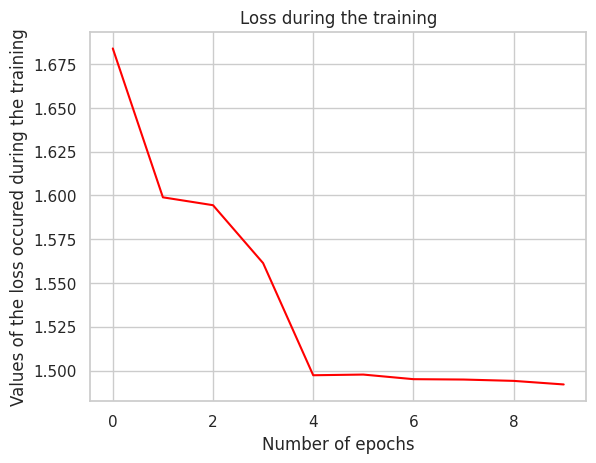

In [40]:
# Loss curve Plot for training set
loss_curve(loss_hist)

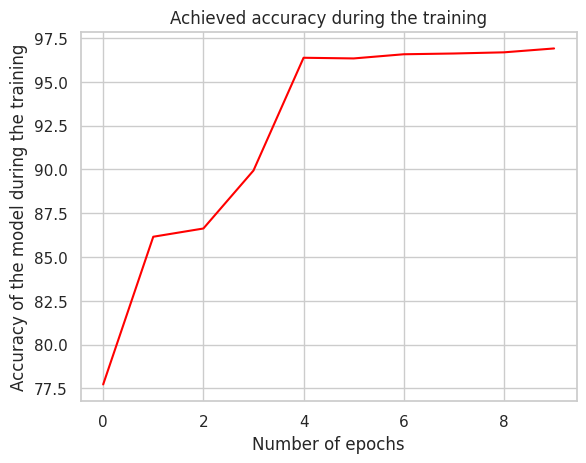

In [41]:
# Loss curve Plot for training set
acc_curve(acc_hist)

In [42]:
# Testing the model on test dataset
import torch
def model_test(CNN, test_set):
    CNN.eval()
    labs = []
    preds = []
    with torch.no_grad():
        for i,t in test_set:
            out = CNN(i)
            _, given = torch.max(out, 1)
            labs.extend(t.numpy())
            preds.extend(given.numpy())
    acc = sum([1 for i, j in zip(labs, preds) if i == j]) / len(labs)
    return acc, labs, preds

In [43]:
test_x, test_y = convert(test_x,test_y)

In [44]:
testing_data = data_loading(test_x,test_y)

In [45]:
# Prediction of accuracy of the model on the test dataset
accuracy, true_lab, pred_lab = model_test(cnn_mod, testing_data)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 97.11%


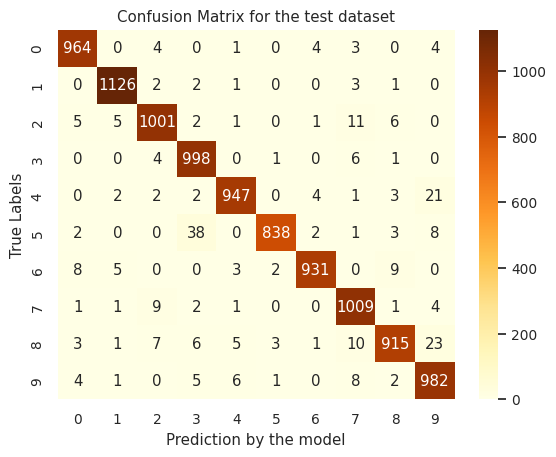

In [80]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_lab,pred_lab)
# Create a heatmap using seaborn
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=True, fmt='d',cmap = 'YlOrBr',cbar='False', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Prediction by the model')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for the test dataset')
plt.show()

In [47]:
from sklearn.metrics import classification_report
report = classification_report(true_lab, pred_lab)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.99      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.99      0.94      0.96       892
           6       0.99      0.97      0.98       958
           7       0.96      0.98      0.97      1028
           8       0.97      0.94      0.96       974
           9       0.94      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [48]:
t_pars, nt_pars=0,0
for i in cnn_mod.parameters():
  if i.requires_grad:
    t_pars += i.numel()
  else:
    nt_pars+= i.numel()
print(f"Total number of parameters are : { t_pars + nt_pars }")
print(f"Total Trainable parameters in the model are: {t_pars}")
print(f" Total Non-Trainable parameters in the model are: {nt_pars}")

Total number of parameters are : 4670
Total Trainable parameters in the model are: 4670
 Total Non-Trainable parameters in the model are:: 0


In [67]:
for i,j in cnn_mod.named_parameters():
    print(f"Parameter name: {i}, Size: {j.size()}")

Parameter name: conv1.weight, Size: torch.Size([16, 1, 7, 7])
Parameter name: conv1.bias, Size: torch.Size([16])
Parameter name: conv2.weight, Size: torch.Size([8, 16, 5, 5])
Parameter name: conv2.bias, Size: torch.Size([8])
Parameter name: conv3.weight, Size: torch.Size([4, 8, 3, 3])
Parameter name: conv3.bias, Size: torch.Size([4])
Parameter name: fc_layer.weight, Size: torch.Size([10, 36])
Parameter name: fc_layer.bias, Size: torch.Size([10])


In [72]:
path_to_file ='/content/drive/MyDrive/Deep Learning 2024/Parameters_CNN.txt'
file = open(path_to_file,'w')
file.write("\n \n  EXPERIMENT 1 PARAMETERS \n \n ")
for i,j in cnn_mod.named_parameters():
        file.write(f"Parameter name: {i}, Size: {j.size()}\n")
        file.write(f"Values: {j}\n\n")
file.close()

# Experiment 2


In [50]:
#Mapping the given lables to the new classification classes
map_label = { 0:0,
              1:1,
              2:2,
              3:2,
              4:3,
              5:2,
              6:0,
              7:1,
              8:2,
              9:3}

In [51]:
# Fetching the data again for new model
new_train_x = im.convert_from_file(data_a)
new_train_y = im.convert_from_file(data_b)
new_test_x = im.convert_from_file(data_c)
new_test_y = im.convert_from_file(data_d)

In [52]:
# Modifying the existing dataset to new dataset
import torch
def data_modified(data_x, data_y, class_mapping):
    new_data = []
    new_labels = []
    for x, y in zip(data_x, data_y):
        new_label = class_mapping[y.item()]
        new_data.append(torch.tensor(x))  # Convert to tensor
        new_labels.append(new_label)
    return torch.stack(new_data), torch.tensor(new_labels,dtype=torch.long)

In [53]:
# Construction of new model for new mutli class classification
cnn_mod2 = CNNArch(4)
loss_cr2, opt2,sch2 = criteria(cnn_mod2)

In [54]:
new_train_x,new_train_y= data_modified(new_train_x,new_train_y,map_label)

In [55]:
new_train_x,new_train_y=convert(new_train_x,new_train_y)

<ipython-input-30-62e6b83f40ab>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32).unsqueeze(1)
<ipython-input-30-62e6b83f40ab>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y,dtype=torch.long)


In [56]:
new_trainset = data_loading(new_train_x,new_train_y)

In [57]:
# Training the model for new dataset
ep2 = 10
acc_hist2, loss_hist2 = model_training(cnn_mod2,new_trainset,opt2,loss_cr2,ep2,sch)

---------------------------------------------------------------
Training the model and noting the loss and accuracy each epoch
---------------------------------------------------------------
 This is Epoch 1 where, Loss is: 0.7962 & Accuracy is: 94.8450%
 This is Epoch 2 where, Loss is: 0.7684 & Accuracy is: 97.5050%
 This is Epoch 3 where, Loss is: 0.7664 & Accuracy is: 97.7033%
 This is Epoch 4 where, Loss is: 0.7655 & Accuracy is: 97.7950%
 This is Epoch 5 where, Loss is: 0.7664 & Accuracy is: 97.7017%
 This is Epoch 6 where, Loss is: 0.7669 & Accuracy is: 97.6500%
 This is Epoch 7 where, Loss is: 0.7663 & Accuracy is: 97.7267%
 This is Epoch 8 where, Loss is: 0.7674 & Accuracy is: 97.6200%
 This is Epoch 9 where, Loss is: 0.7680 & Accuracy is: 97.5483%
 This is Epoch 10 where, Loss is: 0.7656 & Accuracy is: 97.8033%


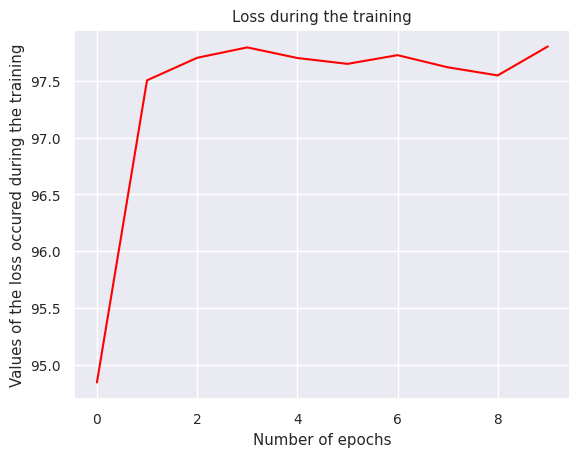

In [58]:
#Plotting the loss curve
loss_curve(loss_hist2)

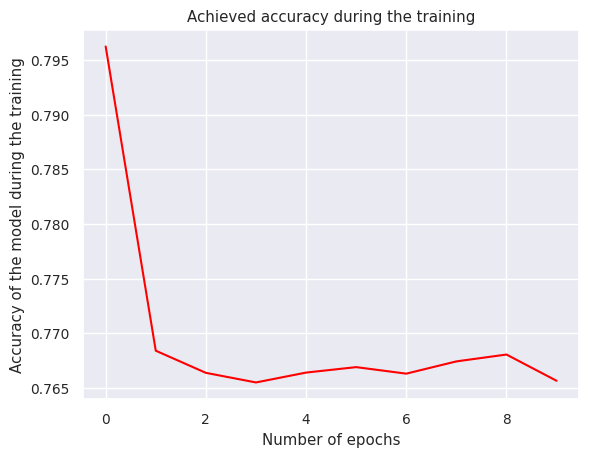

In [59]:
# Plotting the accuracy curve
acc_curve(acc_hist2)

In [60]:
new_test_x,new_test_y= data_modified(new_test_x,new_test_y,map_label)

In [61]:
new_test_x,new_test_y=convert(new_test_x,new_test_y)

<ipython-input-30-62e6b83f40ab>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32).unsqueeze(1)
<ipython-input-30-62e6b83f40ab>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y,dtype=torch.long)


In [62]:
new_testset = data_loading(new_test_x,new_test_y)

In [63]:
# Testing the accuracy on new test dataset
accuracy2, tr_lab, pr_lab = model_test(cnn_mod2, new_testset)
print(f'Accuracy: {accuracy2 * 100:.2f}%')

Accuracy: 96.10%


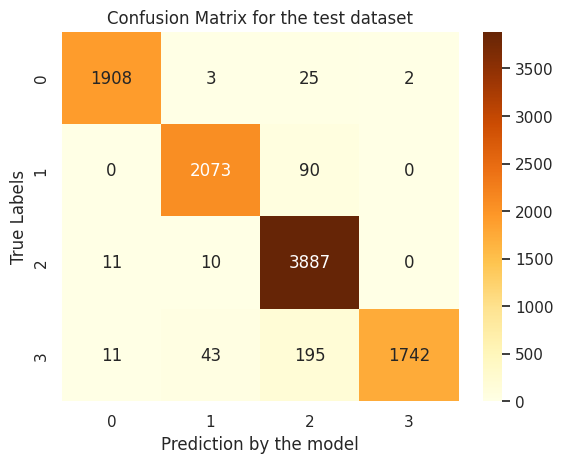

In [85]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(tr_lab,pr_lab)
# Create a heatmap using seaborn
sns.set(font_scale=1.0)
sns.heatmap(cm, annot=True, fmt='d',cmap = 'YlOrBr',cbar='False', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Prediction by the model')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for the test dataset')
plt.show()

In [66]:
from sklearn.metrics import classification_report
rep2 = classification_report(tr_lab, pr_lab)
print("Classification Report:\n", rep2)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1938
           1       0.97      0.96      0.97      2163
           2       0.93      0.99      0.96      3908
           3       1.00      0.87      0.93      1991

    accuracy                           0.96     10000
   macro avg       0.97      0.95      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [70]:
t_pars2, nt_pars2=0,0
for i in cnn_mod2.parameters():
  if i.requires_grad:
    t_pars2 += i.numel()
  else:
    nt_pars2+= i.numel()
print(f"Total number of parameters are : { t_pars2 + nt_pars2 }")
print(f"Total Trainable parameters in the model are: {t_pars2}")
print(f" Total Non-Trainable parameters in the model are:: {nt_pars2}")

Total number of parameters are : 4448
Total Trainable parameters in the model are: 4448
 Total Non-Trainable parameters in the model are:: 0


In [68]:
for i,j in cnn_mod2.named_parameters():
    print(f"Parameter name: {i}, Size: {j.size()}")

Parameter name: conv1.weight, Size: torch.Size([16, 1, 7, 7])
Parameter name: conv1.bias, Size: torch.Size([16])
Parameter name: conv2.weight, Size: torch.Size([8, 16, 5, 5])
Parameter name: conv2.bias, Size: torch.Size([8])
Parameter name: conv3.weight, Size: torch.Size([4, 8, 3, 3])
Parameter name: conv3.bias, Size: torch.Size([4])
Parameter name: fc_layer.weight, Size: torch.Size([4, 36])
Parameter name: fc_layer.bias, Size: torch.Size([4])


In [73]:
path_to_file ='/content/drive/MyDrive/Deep Learning 2024/Parameters_CNN.txt'
file = open(path_to_file,'a')
file.write("\n \n  EXPERIMENT 2 PARAMETERS \n \n ")
for i,j in cnn_mod2.named_parameters():
        file.write(f"Parameter name: {i}, Size: {j.size()}\n")
        file.write(f"Values: {j}\n\n")
file.close()